In [4]:
from mlfinlab.features.kca import KCA
from mlfinlab.features.fft import FFT
from mlfinlab.features.lowess import LOWESS
from mlfinlab.util.generate_dataset import generate_periodic_signal
from mlfinlab.datasets.load_datasets import load_dollar_bar_sample
from utils import plotting

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Introduction

> **Underlying Literature**: Research and code have been adapted from [Kinetic Component Analysis (KCA) paper](https://ssrn.com/abstract=2422183) by Marcos Lopez de Prado and Riccardo Rebonato.

In this notebook, we showcase our research on several noise reduction methods implemented from the above paper in MLFinLab against a simple periodic sine wave with gaussian noise for baselining purposes. We then apply the same methods to the price of the [E-Mini S&P500 Future Contract (ES00)](https://www.marketwatch.com/investing/future/sp%20500%20futures).

We first explore the LOWESS method against a sine wave. Then we repeat the same procedure with FFT and KCA. We highlight KCA's unique attributes of providing confidence intervals and forecasting capabilities.

### Table of Contents
- [Locally Weighted Scatterplot Smoothing (LOWESS)](#lowess)
- [Fast Fourier Transform (FFT)](#fft)
- [Kinetic Component Analysis (KCA)](#kca)
- [Application of methods to E-Mini Futures Contract](#emini)
- [Final Remarks](#final)


### Sine wave with gaussian noise

Below is the signal which we will be operating our methods against. It is a periodic sine wave with gaussian noise. The sine wave has a period of 5 and a total of 300 observations, which for our purposes we can define across time. We plot the observations (measurement) over the original sine wave signal with the noise removed.

Our objective with the noise reduction methods is to take the observations and match as much as possible the underlying signal, in this case, the underlying sine wave.

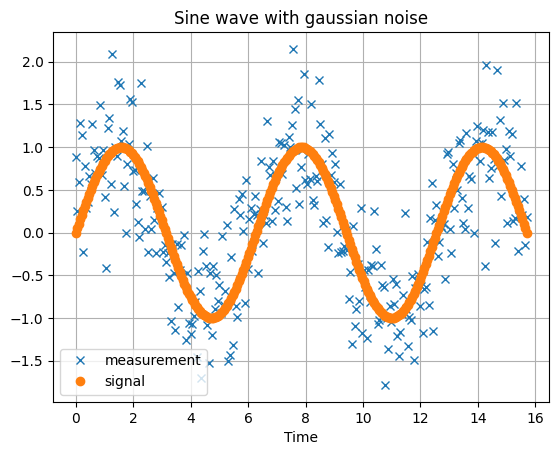

In [5]:
(t, signal, z) = generate_periodic_signal(10, 300, 0.5)
sine_df = pd.DataFrame(z, index=t)
plotting.plot_periodic_signal(t, z, signal)

## Locally Weighted Scatterplot Smoothing (LOWESS) <a class="anchor" id="lowess"></a>

LOWESS fits weighted linear regressions to localized subsets of data in order to filter noise by point.

Below we plot our LOWESS generated signals with decreasing values of `fraction`. The smaller the fraction provided to LOWESS the greater our approximation to the real signal as seen with `fraction=0.1`. The authors highlight the "bumpiness" as the cost to the closer approximation given less fraction of data used by LOWESS.


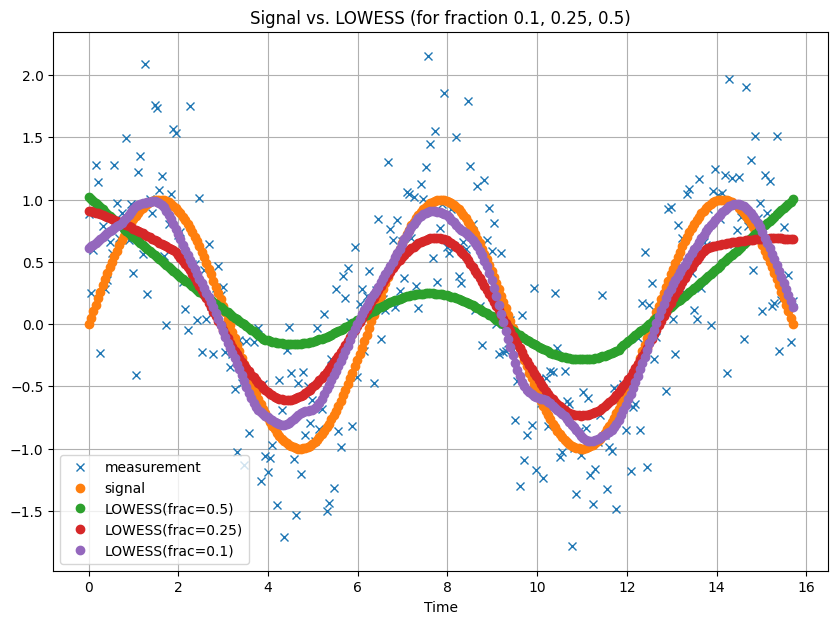

In [6]:
lowess_dot_1 = LOWESS(sine_df, 0.1).generate_signal()
lowess_dot_5 = LOWESS(sine_df, 0.5).generate_signal()
lowess_dot_25 = LOWESS(sine_df, 0.25).generate_signal()

plotting.plot_lowess_vs_periodic(t, z, signal, lowess_dot_1, lowess_dot_25, lowess_dot_5)

## Fast Fourier Transform (FTT) <a class="anchor" id="fft"></a>

Fast Fourier Transform is an algorithm that transforms a signal from time-domain to frequency-domain. FFT is
applied to functions the same way PCA is applied to vector spaces.

In order to avoid overfitting noise during the signal extraction the authors provide a mechanism to halt the algorithm. At a certain threshold probability `min_alpha` is used to reach a point of 

See plot below for varying `min_alpha`. 

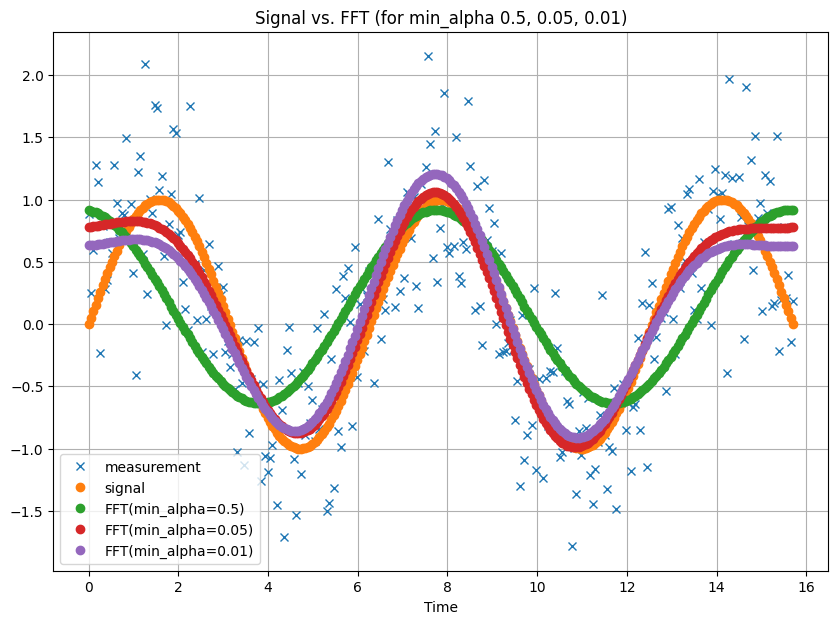

In [7]:
fft_alpha_5 = FFT(sine_df, min_alpha=0.5)
fft_alpha_01 = FFT(sine_df, min_alpha=0.01)
fft_alpha_05 = FFT(sine_df, min_alpha=0.05)

fft_alpha_5_signal = fft_alpha_5.generate_signal()
fft_alpha_01_signal = fft_alpha_01.generate_signal()
fft_alpha_05_signal = fft_alpha_05.generate_signal()

plotting.plot_fft_vs_periodic(t, z, signal, fft_alpha_5_signal, fft_alpha_01_signal, fft_alpha_05_signal)


## Kinetic Component Analysis (KCA) <a class="anchor" id="kca"></a>

The authors present Kinetic Component Analysis (KCA), as a state-space application that extracts the
signal from a series of noisy measurements by applying a Kalman Filter on a Taylor expansion
of a stochastic process. In simple terms, KCA enables us to study the economic observables such
as stock or futures prices as a particle moving in state-space. With this treatment, KCA gives us
a variety of aspects to study such economic observables such as its decomposition into well-known classical
mechanics components; position, velocity and acceleration.


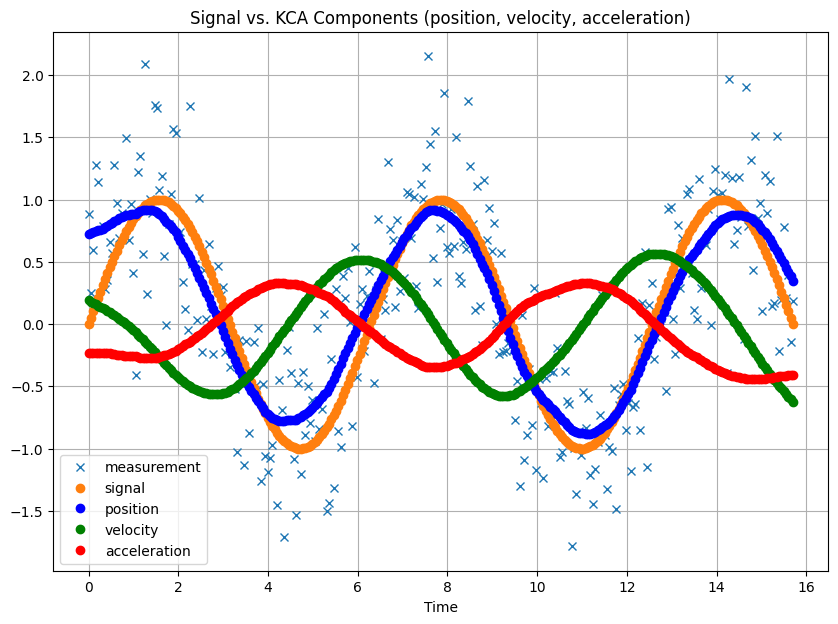

In [8]:
kca = KCA(sine_df, include_std=True, sigma=2, seed=0.001)
_ = kca.generate_signal()
position = kca.get_position_signal()
velocity = kca.get_velocity_signal()
acceleration = kca.get_acceleration_signal()

plotting.plot_kca_components(t, z, signal, position, velocity, acceleration)

Below we appreciate our KCA results and all the additional information it is able to produce all nicely bundled in a pandas `DataFrame`. We note that not only do we have produced kinetic component signals but they include standard deviations and confidence intervals (upper and lower).

In [9]:
kca.dataframe

,0,position,velocity,acceleration,position_std,velocity_std,acceleration_std,position_lower_ci,position_upper_ci,velocity_lower_ci,velocity_upper_ci,acceleration_lower_ci,acceleration_upper_ci
0.000000,0.882026,0.721281,0.192030,-0.235602,0.057711,0.094782,0.070904,0.605859,0.836703,0.002466,0.381594,-0.377411,-0.093794
0.052535,0.252589,0.728499,0.181228,-0.233684,0.064536,0.098091,0.080041,0.599428,0.857571,-0.014954,0.377410,-0.393767,-0.073601
0.105070,0.594246,0.738279,0.170436,-0.233116,0.070085,0.100915,0.087314,0.598109,0.878450,-0.031395,0.372267,-0.407745,-0.058488
0.157605,1.277400,0.748464,0.159570,-0.233018,0.074699,0.103350,0.093253,0.599066,0.897863,-0.047130,0.366270,-0.419524,-0.046512
0.210140,1.142376,0.754679,0.148829,-0.231614,0.078591,0.105467,0.098180,0.597498,0.911861,-0.062105,0.359763,-0.427974,-0.035255
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15.497823,0.777042,0.488165,-0.539554,-0.415731,0.142929,0.302223,0.261500,0.202306,0.774024,-1.143999,0.064891,-0.938731,0.107270
15.550358,0.205816,0.453108,-0.561719,-0.413220,0.152191,0.314381,0.265316,0.148725,0.757490,-1.190481,0.067044,-0.943851,0.117412
15.602893,0.396354,0.418486,-0.583554,-0.411338,0.163046,0.326807,0.268973,0.092394,0.744578,-1.237169,0.070060,-0.949284,0.126607
15.655428,-0.147214,0.382861,-0.605079,-0.409506,0.175614,0.339456,0.272451,0.031633,0.734088,-1.283991,0.073833,-0.954408,0.135395


The plot below shows an additional feature of KCA, which is the ability to produce confidence intervals on our signal processing. 

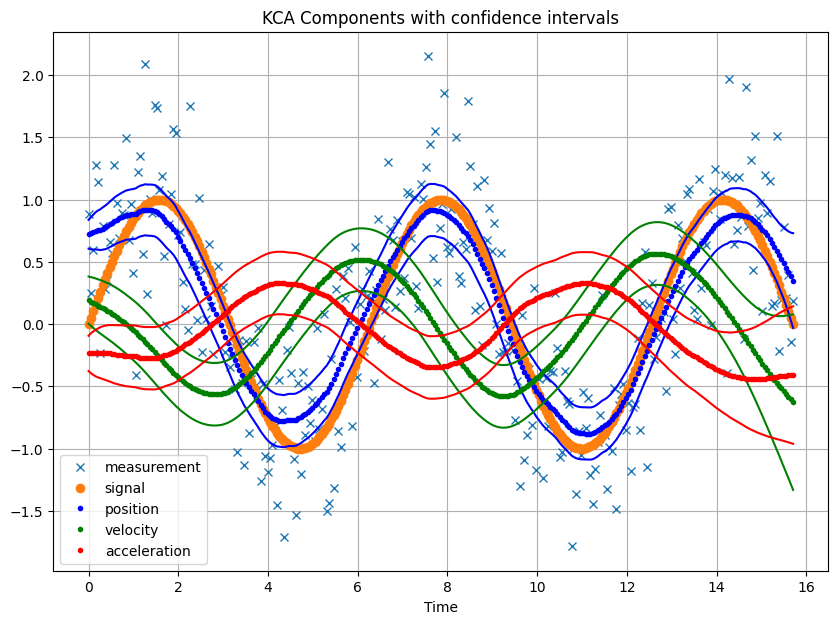

In [10]:
plotting.plot_kca_confidence_intervals(t, z, signal, kca.dataframe)

In the following plot, we explore different values of `seed`, which is an initialization parameter of the state transition covariance matrices for the Kalman filter. Note that the greater the value (e.g `seed=0.1`), the greater the signal overfits the data. Note that `seed=0.1` seems to approximate the measurements rather than the signal, which is what we want to achieve if we are to remove the noise from the signal.

The `seed` value tells the filter where we are to find most of the signals noise. If the value is high, we are telling the filter that noise mostly originates from the state rather than the measurements / observations. So apply judicious knowledge of the system to find a value that works. You will most likely need to explore several values before one works with your intended results.

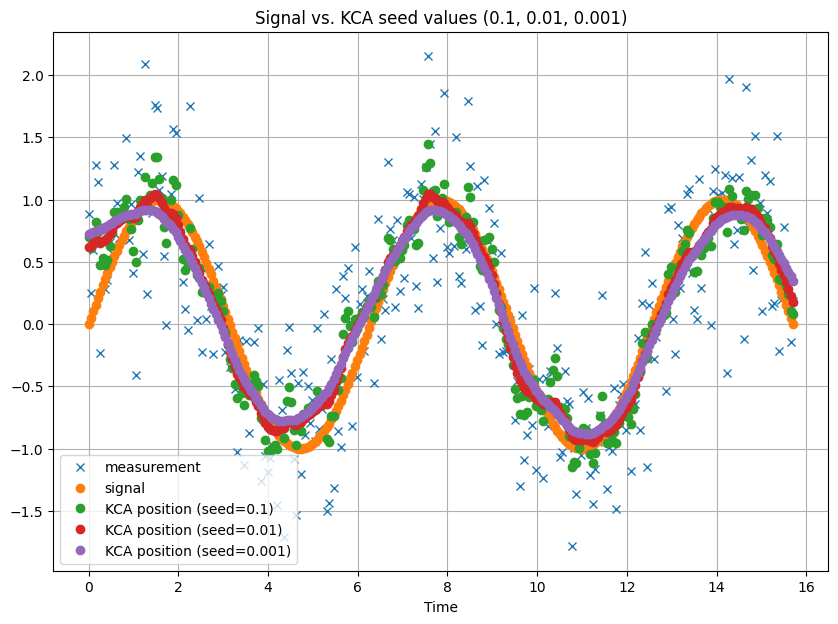

In [11]:
kca = KCA(sine_df, seed=1)
kca_large_seed_signal = kca.generate_signal()
kca = KCA(sine_df, seed=0.01)
kca_large_medium_signal = kca.generate_signal()
kca = KCA(sine_df, seed=0.001)
kca_large_small_signal = kca.generate_signal()

plotting.plot_kca_seed_param(t, z, signal, kca_large_seed_signal, kca_large_medium_signal, kca_large_small_signal)

Another distinctive quality of KCA is the ability to provide forecasts. The plot below shows KCA forecasting the next 20 points of the sine wave signal. Note how KCA position plot seems to continue on the path of a traditional sine wave which is the signal we are trying to extract from the noise of the measurements.

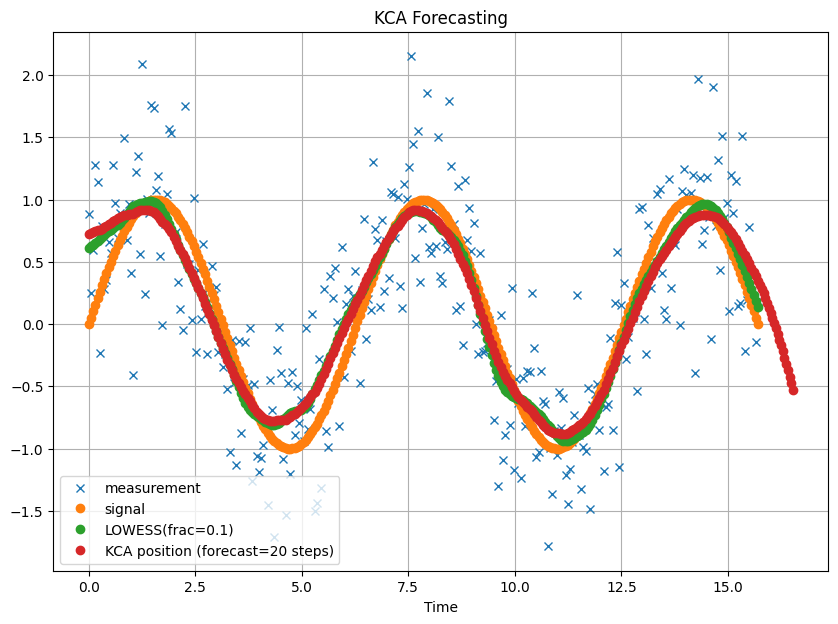

In [12]:
_ = kca.generate_signal_with_forecast(num_to_forecast=20)
forecast_df = kca.forecast_df

plotting.plot_kca_forecasting(t, z, signal, lowess_dot_1, forecast_df)

Finally for KCA, we compare other noise reduction techniques with KCA's position signal.

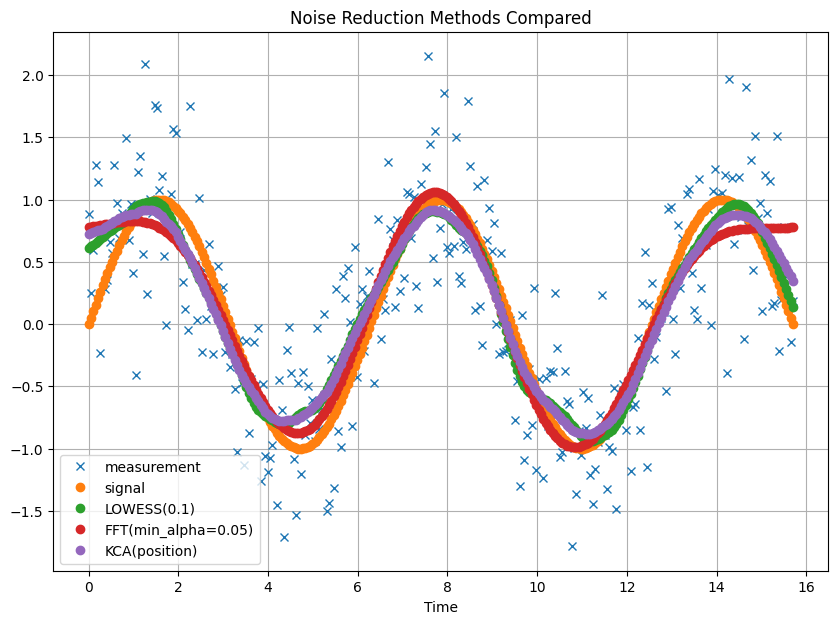

In [13]:
plotting.plot_kca_vs_other_methods(t, z, signal, position, lowess_dot_1, fft_alpha_05_signal)

## Application of methods to E-Mini Futures Contract <a class="anchor" id="emini"></a>

In the following cells, we employ our previous noise reduction methods to the price of the E-Mini S&P500 Future Contract (ES00). We load the dollar bars (close price) of ES00 for the month of January 2015.

In [14]:
emini = load_dollar_bar_sample()[["close"]]
emini

,close
date_time,
2015-01-01 23:00:23.723,2056.75
2015-01-02 07:07:35.156,2064.00
2015-01-02 09:35:57.204,2060.50
2015-01-02 12:59:42.176,2061.00
2015-01-02 14:19:33.847,2063.75
...,...
2015-01-29 15:17:46.613,1992.75
2015-01-29 15:24:43.031,1988.50
2015-01-29 15:31:19.688,1993.00


Below we apply LOWESS to the price path of E-Mini. Note how the LOWESS fit (`frac=0.5`) smoothens out the E-Mini price path.

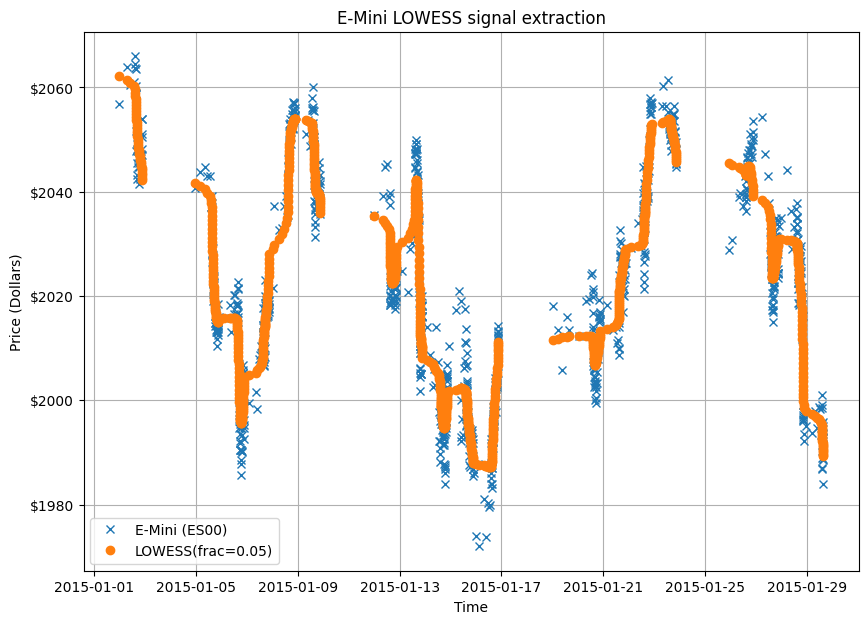

In [15]:
lowess_emini = LOWESS(emini, 0.05)
lowess_signal = lowess_emini.generate_signal()
lowess_df = lowess_emini.dataframe

plotting.plot_emini_lowess(lowess_df)

Below we apply FFT to the E-Mini price path. As compared to LOWESS, we see LOWESS does smoothen out the price path a bit more by filtering out more noise.

We note that it's a bit difficult to quantify the relative performance here as no "true" underlying signal exists that can tell us if the technique applied is right or wrong. This might be dependent on the underlying application for which you want to be reducing the noise of a given economic observable, such as the price of a futures contract in our case.

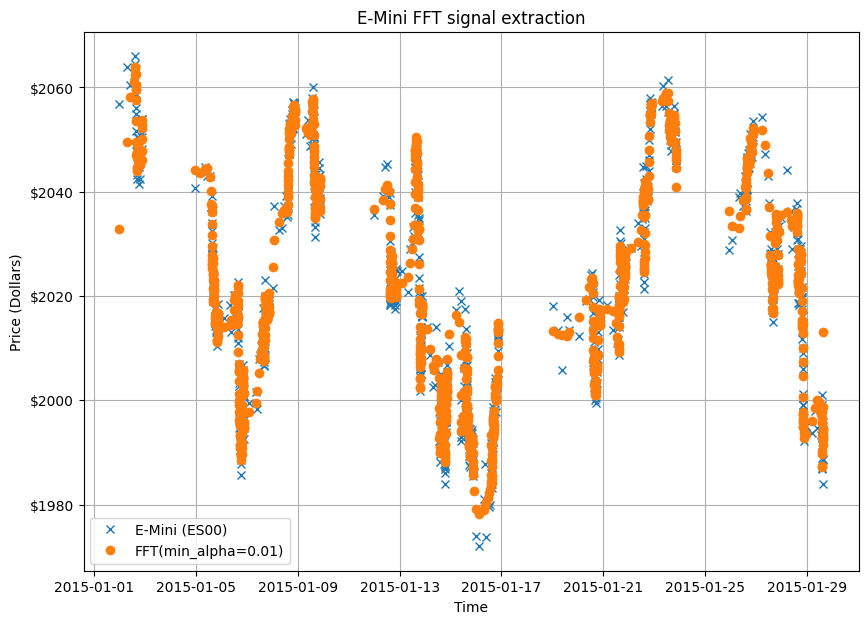

In [16]:
fft_emini = FFT(emini, min_alpha=0.01)
fft_signal = fft_emini.generate_signal()
fft_df = fft_emini.dataframe
fft_df

plotting.plot_emini_fft(fft_df)

Finally, we apply KCA to the E-Mini contract price path. Note the noise reduction but also the confidence interval (`sigma=2`) on such estimations of the true signal. We select `seed=0.1` to showcase our results as we noted smaller values led to even smoother signals of the price and did not compare well with other methods presented.

Afterwards, we also showcase an even smaller value of `seed` to see how it leads to an even smoother underlying signal of the price of E-Mini.

In [17]:
kca = KCA(emini, include_std=True, sigma=2, seed=0.1)
kca.generate_signal()
emini_kca = kca.dataframe


emini_kca

,close,position,velocity,acceleration,position_std,velocity_std,acceleration_std,position_lower_ci,position_upper_ci,velocity_lower_ci,velocity_upper_ci,acceleration_lower_ci,acceleration_upper_ci
date_time,,,,,,,,,,,,,
2015-01-01 23:00:23.723,2056.75,1628.131538,0.006144,-8.811374e-07,0.458149,1.000000,1.000000,1627.215239,1629.047837,-1.993856,2.006144,-2.000001,1.999999
2015-01-02 07:07:35.156,2064.00,1842.811974,0.006754,-1.136090e-06,9.596022,1.048809,1.048809,1823.619931,1862.004017,-2.090863,2.104372,-2.097619,2.097617
2015-01-02 09:35:57.204,2060.50,1950.830803,0.007061,-1.264398e-06,10.752146,1.095445,1.095445,1929.326512,1972.335094,-2.183829,2.197952,-2.190891,2.190889
2015-01-02 12:59:42.176,2061.00,2005.964795,0.007218,-1.329914e-06,11.028708,1.140175,1.140175,1983.907379,2028.022211,-2.273133,2.287569,-2.280352,2.280350
2015-01-02 14:19:33.847,2063.75,2034.559631,0.007299,-1.363919e-06,11.098416,1.183216,1.183216,2012.362799,2056.756462,-2.359133,2.373731,-2.366433,2.366431
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-29 15:17:46.613,1992.75,1991.853678,0.007147,-1.339002e-06,11.134398,10.024974,10.024969,1969.584881,2014.122474,-20.042801,20.057094,-20.049939,20.049936
2015-01-29 15:24:43.031,1988.50,1990.584368,0.007143,-1.337495e-06,11.169452,10.029960,10.029955,1968.245464,2012.923272,-20.052777,20.067063,-20.059912,20.059909
2015-01-29 15:31:19.688,1993.00,1990.320186,0.007142,-1.337181e-06,11.305308,10.034944,10.034939,1967.709570,2012.930802,-20.062746,20.077030,-20.069879,20.069877


The following plot shows E-Mini's KCA position with confidence intervals and appears comparable to previous methods shown.

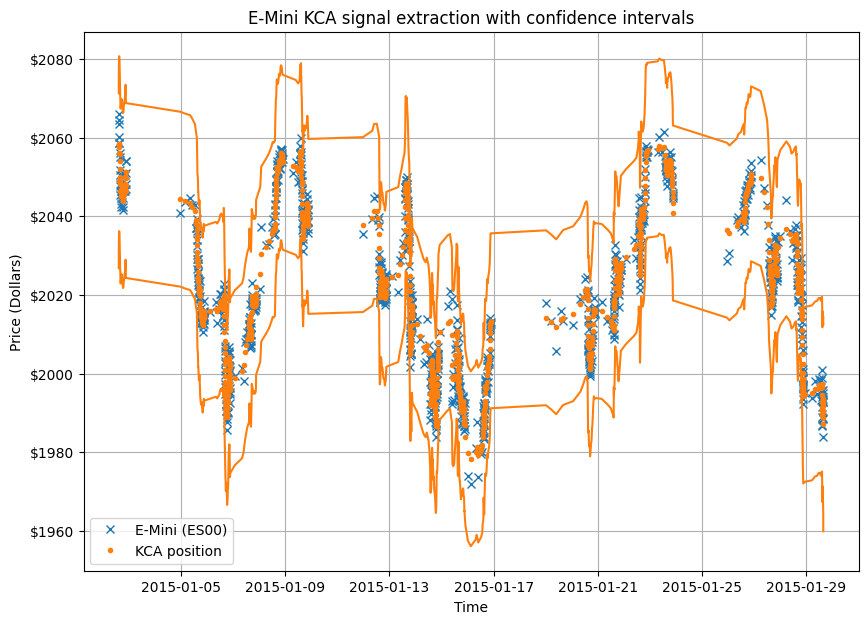

In [18]:
plotting.plot_emini_kca_position_with_ci(emini_kca)

Applying a smaller value of `seed=0.0001` to our KCA signal generation shows a much smoother underlying signal removing a considerable amount of measurements (e.g. noise).

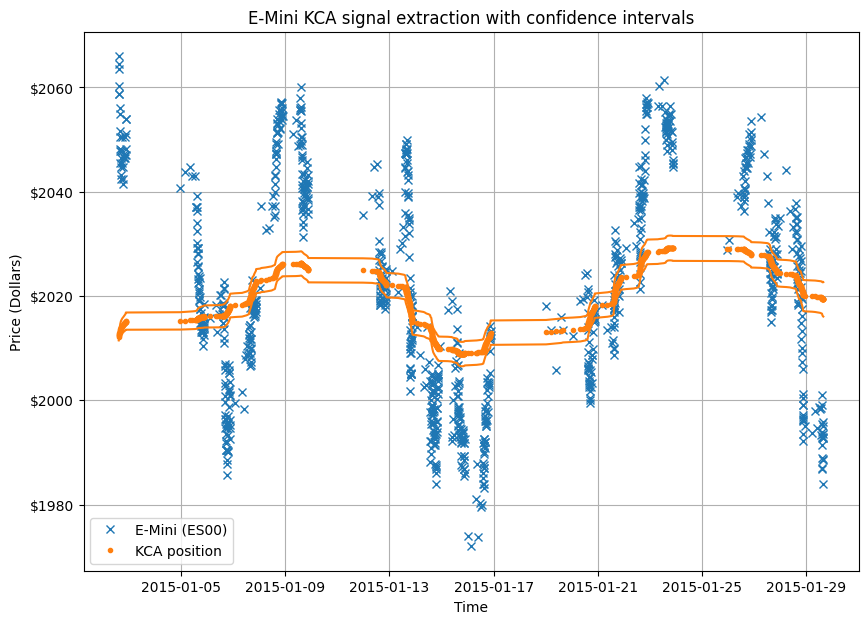

In [19]:
smoother_kca = KCA(emini, include_std=True, sigma=2, seed=0.0001)
smoother_kca.generate_signal()
plotting.plot_emini_kca_position_with_ci(smoother_kca.dataframe)

Finally, we visualize KCA components for the E-Mini futures contract price path.

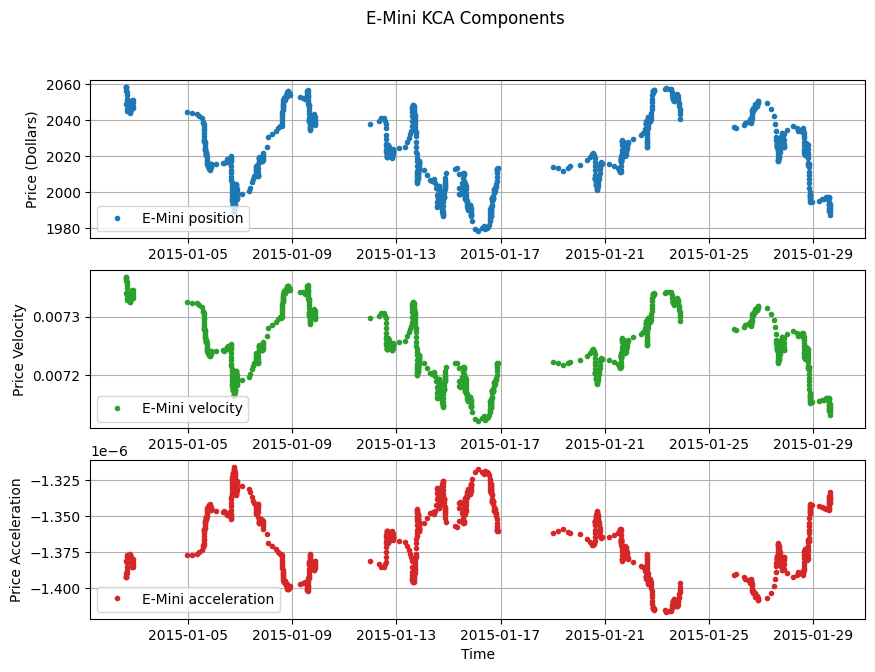

In [20]:
plotting.plot_emini_kca_components(emini_kca)

## Final Remarks <a class="anchor" id="final"></a>

We've explored several noise reduction methods applicable to economic observables. We saw LOWESS, FFT, and finally KCA as potential tools to remove noisy components from an underlying signal.

Potential future work on these methods, particularly KCA, is exploring financial inertia, microstructurual nois,e and finally momentum / trend following.

## References


* [de Prado, M.L, Rebonato, R., 2016. Kinetic Component Analysis (KCA). Available at SSRN 2422183.](https://ssrn.com/abstract=2422183)
